<a href="https://colab.research.google.com/github/DABallentine/knowledge_discovery_charlotte/blob/main/Jupiter%20Notebooks/Predictive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Charlotte 311 Service Request Analysis

## **Predictive Modeling** 

This notebook uses the output of the notebook "Data Preparation for Modeling", areas.zip, to predict median income and historic redlining based on 311 Service Request behavior.

In [ ]:
# Import necessary packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from statsmodels.stats.stattools import durbin_watson
#!pip install symbulate
import symbulate as sm
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import time
from sklearn.feature_selection import RFECV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
%matplotlib inline

     |████████████████████████████████| 44 kB 2.0 MB/s 


In [ ]:
# Read in the data
areas = pd.read_csv('https://github.com/DABallentine/knowledge_discovery_charlotte/blob/main/Data/areas.zip?raw=true', compression='zip', index_col=0)
areas.head()

,311 DOCUMENT_VOL,ADMINISTRATIVE ACTIONS_VOL,ADOPT-A PICKUP SWS_VOL,ANIMAL FOUND REPORT_VOL,BLOCKAGE_VOL,BOARDED UP STRUCTURE_VOL,BULKY ITEM_VOL,CART_VOL,CLEANLINESS_VOL,COMPLAINT_VOL,CONTENT IMPROVEMENT PROG_VOL,CUSTOMER FEEDBACK_VOL,CWP_VOL,DEAD ANIMAL COLLECTION_VOL,DISABILITY ACT_VOL,DISABLED SERVICE_VOL,ESCALATION REQUEST_VOL,FIELD OBSERVED PROBLEM_VOL,GARBAGE_VOL,HNS HEALTH AND SANITATION_VOL,HNS HOUSING_VOL,MISSED SERVICE_VOL,NON_RECYCLABLE ITEMS_VOL,PARK & REC SVC REQUEST_VOL,RECYCLABLE ITEMS_VOL,RECYCLING_VOL,REQUEST FOR SPEAKER_VOL,STW CNTY WATER QUALITY_VOL,STW OTHER_VOL,SW ONLY-DOOR HANGER LEFT_VOL,TIRES_VOL,TRANSPORTATION_VOL,UTILITY VERIFICATION LTR_VOL,VIOLATIONS_VOL,WEATHER AND ENVIRONMENTAL_VOL,YARD WASTE_VOL,ZON GENERAL INFO INQUIRY_VOL,ZONING_VOL,ZONING/COMPLAINT/ INSPECT_VOL,311 DOCUMENT_STD,...,ANIMAL FOUND REPORT_LATE,BLOCKAGE_LATE,BOARDED UP STRUCTURE_LATE,BULKY ITEM_LATE,CART_LATE,CLEANLINESS_LATE,COMPLAINT_LATE,CONTENT IMPROVEMENT PROG_LATE,CUSTOMER FEEDBACK_LATE,CWP_LATE,DEAD ANIMAL COLLECTION_LATE,DISABILITY ACT_LATE,DISABLED SERVICE_LATE,ESCALATION REQUEST_LATE,FIELD OBSERVED PROBLEM_LATE,GARBAGE_LATE,HNS HEALTH AND SANITATION_LATE,HNS HOUSING_LATE,MISSED SERVICE_LATE,NON_RECYCLABLE ITEMS_LATE,PARK & REC SVC REQUEST_LATE,RECYCLABLE ITEMS_LATE,RECYCLING_LATE,REQUEST FOR SPEAKER_LATE,STW CNTY WATER QUALITY_LATE,STW OTHER_LATE,SW ONLY-DOOR HANGER LEFT_LATE,TIRES_LATE,TRANSPORTATION_LATE,UTILITY VERIFICATION LTR_LATE,VIOLATIONS_LATE,WEATHER AND ENVIRONMENTAL_LATE,YARD WASTE_LATE,ZON GENERAL INFO INQUIRY_LATE,ZONING_LATE,ZONING/COMPLAINT/ INSPECT_LATE,CRIME_SCORE,CRIME_REQUEST_INT,HISTORIC_REDLINING,INCOME
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2016_10.0,1.127806,0.751871,0.0,0.0,0.0,0.0,0.751871,6.766838,0.000000,0.000000,0.0,0.0,0.0,1.503742,0.0,0.0,0.0,0.0,1.127806,4.511225,1.879677,0.375935,31.954512,0.0,6.766838,0.375935,0.0,0.0,0.0,0.0,0.375935,0.751871,0.0,0.375935,0.375935,0.375935,0.375935,1.503742,0.375935,0.438986,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.333333,0.083333,0.2,0.0,0.176471,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.007744,0.486657,Y,42458.056370
10_2016_100.0,0.637888,0.000000,0.0,0.0,0.0,0.0,0.000000,1.275775,0.000000,0.318944,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.318944,3.827326,0.000000,0.000000,13.395640,0.0,4.784157,0.000000,0.0,0.0,0.0,0.0,0.000000,0.318944,0.0,0.000000,0.000000,0.637888,0.000000,0.318944,0.000000,0.293544,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.119048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004914,0.128403,N,46759.465505
10_2016_101.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.323053,0.323053,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.323053,0.323053,0.000000,1.615263,0.0,1.615263,0.000000,0.0,0.0,0.0,0.0,0.000000,0.323053,0.0,0.000000,0.000000,0.323053,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.600000,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003425,0.017704,N,41973.411765
10_2016_102.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.633837,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.316918,3.486103,0.316918,0.000000,6.338370,0.0,1.901511,0.000000,0.0,0.0,0.0,0.0,0.000000,0.633837,0.0,0.000000,0.000000,0.633837,0.316918,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.200000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.002829,0.041249,N,47589.226947
10_2016_103.0,0.323053,0.000000,0.0,0.0,0.0,0.0,0.000000,0.646105,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.938316,0.000000,0.000000,6.138000,0.0,1.938316,0.323053,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.969158,0.000000,0.000000,0.000000,0

In [ ]:
# Split training, validation, and test data sets. 
X = areas.iloc[:, 0:156]
y = areas.iloc[:, 159]
y_cat = areas.iloc[:, 158]

X_sub, X_test, y_sub, y_test = train_test_split(X, y, test_size=0.1, random_state=161)
X_train, X_val, y_train, y_val = train_test_split(X_sub, y_sub, test_size=0.2, random_state=161)

# Set friendlier printing parameters
np.set_printoptions(precision=3)

### Pre-modeling Checks

#### Target normality

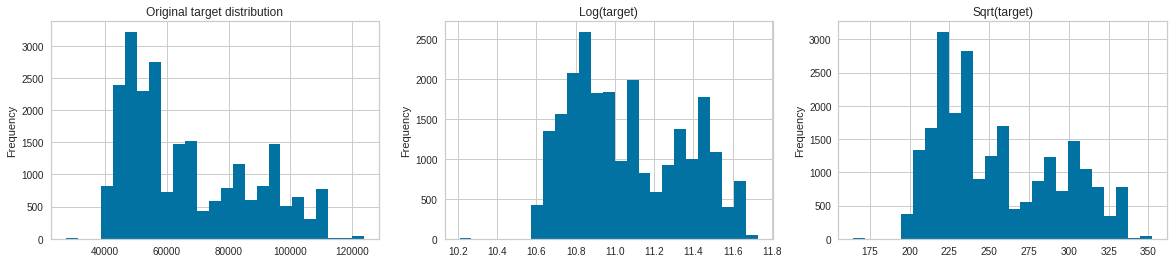

In [ ]:
# Observe continuous target variable distribution
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.title("Original target distribution")
y.plot.hist(bins=25)

plt.subplot(132)
plt.title("Log(target)")
y_log = np.log(y)
y_log.plot.hist(bins=25)

plt.subplot(133)
plt.title("Sqrt(target)")
y_root = np.sqrt(y)
y_root.plot.hist(bins=25)

plt.show()

Neither of the transformations makes substantial improvement in the normality of the distribution, so we'll keep the target variable as is for the baseline, and perhaps try a transformation for a modest improvement in fit. Regardless, for the purpose of this investigation we are more interested in the relative significance and effect of features than predictive accuracy.

#### Multicollinearity

In [ ]:
# Compute Variance Inflation Factors (VIF) to confirm multicollinearity

# Add intercept term to X
X['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif[vif.VIF >= 5].sort_values('VIF', ascending=False))

                         variables        VIF
95     FIELD OBSERVED PROBLEM_DIST  89.768298
102          RECYCLABLE ITEMS_DIST  69.927978
24            RECYCLABLE ITEMS_VOL  69.001344
107  SW ONLY-DOOR HANGER LEFT_DIST  63.801253
22        NON_RECYCLABLE ITEMS_VOL  63.122790
..                             ...        ...
59                 HNS HOUSING_STD   5.947520
76                      ZONING_STD   5.834913
58   HNS HEALTH AND SANITATION_STD   5.764637
46                        CART_STD   5.460051
63            RECYCLABLE ITEMS_STD   5.305110

[115 rows x 2 columns]


**With 115 of 156 predictors showing VIF values above 5, we clearly have a multicollinearity issue. Since the predictor set is so large, we will try a stepwise selection method as opposed to manually removing variables**

### Linear Model Baseline

In [ ]:
# Instantiate the model
lm = linear_model.LinearRegression()

# Fit the model and estimate the validation error
lm.fit(X_train, y_train)
y_pred = lm.predict(X_val)

# Print mean validation errors and R-squared
pd.options.display.float_format = '{:.4f}'.format
scores = pd.DataFrame(0, columns=['R^2', 'MAPE', 'MAE'], index=['Val'])
scores.loc['Val','R^2'] = r2_score(y_val, y_pred)
scores.loc['Val','MAPE'] = mean_absolute_percentage_error(y_val, y_pred)
scores.loc['Val','MAE'] = mean_absolute_error(y_val, y_pred)
display(scores)

# Calculate F-statistic and its p-value
Rsq = scores.loc['Val','R^2']
n = X_train.shape[0]
k = X_train.shape[1]
dfN = n - k
fstat = (Rsq/(1-Rsq))*((dfN-1)/k)
f_pval = 1 - sm.F(k - 1, n - k).cdf(fstat)
print("F-statistic:", np.round(fstat,3))
print("F's p-value:", f_pval)

# Check for autocorrelation. Since the records are for the same neighborhoods at one month intervals, it is certainly possible they are autocorrelated and is worth verifying.
print("Durbin-Watson score:", durbin_watson(y_val - y_pred))

# Collect the model coefficients
idict = {'Coefficient':lm.intercept_}
idf = pd.DataFrame(data=idict,index=['Intercept'])
cdf = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=["Coefficient"])
cdf = pd.concat([idf,cdf], axis=0)

# Calculate and add in standard errors, t-statistics, and p-values
X_train_wint = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train.reset_index(drop=True))) # X_train with constant intercept column added
train_pred=lm.predict(X_train)
MSE = sum(np.square(train_pred - y_train))/(dfN-1)
var = MSE*(np.linalg.inv(np.dot(X_train_wint.T, X_train_wint)).diagonal())
se = np.sqrt(var)
cdf['Standard Error'] = se
cdf['t-statistic'] = cdf['Coefficient'] / cdf['Standard Error']
cdf['Probabilities'] = [2*scipy.stats.t.sf(abs(i), dfN) for i in cdf['t-statistic']]

# Add some pretty R-style significance codes
sig_codes = ["***", "**", "*", ".", ""]
sig_levels = [-np.inf, 0.001, 0.01, 0.05, 0.1, np.inf]
cdf['*'] = pd.cut(cdf['Probabilities'], bins=sig_levels, labels=sig_codes)
cdf[cdf.Probabilities < 0.001]

## Code in this section for calculating errors, t-stats, and p-values adapted from https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression. Thanks @JARH!

,R^2,MAPE,MAE
Val,0.3027,0.2126,13602.0647


F-statistic: 46.344
F's p-value: 1.1102230246251565e-16
Durbin-Watson score: 1.927218597761597


,Coefficient,Standard Error,t-statistic,Probabilities,*
Intercept,71893.2629,426.4519,168.5847,0.0000,***
311 DOCUMENT_VOL,-9092.4530,1653.6120,-5.4985,0.0000,***
CART_VOL,-1733.2833,242.2004,-7.1564,0.0000,***
HNS HEALTH AND SANITATION_VOL,3844.7399,522.8189,7.3539,0.0000,***
MISSED SERVICE_VOL,2187.6764,655.0629,3.3396,0.0008,***
NON_RECYCLABLE ITEMS_VOL,-1925.6052,122.9738,-15.6587,0.0000,***
SW ONLY-DOOR HANGER LEFT_VOL,-50629.0623,13941.0017,-3.6317,0.0003,***
TIRES_VOL,8768.8238,1890.2225,4.6390,0.0000,***
YARD WASTE_VOL,-9282.8607,1626.8642,-5.7060,0.0000,***
CART_STD,2814.7470,696.3820,4.0420,0.0001,***


**Initial observations**
- The baseline model clearly shows that many features are statistically significant in predicting median income for a given neighborhood. However, we alraedy know we have a major multicollinearity issue which we need to address before putting too much stock in the standard errors of the coefficients or making determinations on statistical significance.

- Given that we know _many_ factors outside of 311 request volume influence the variability of median income, the relatively low R-squared value of 0.3 is unsurprising, and in fact represents an explanation of more of the variance in median income than we had anticipated.

- The Durbin-Watson score of 1.9 indicates almost no autocorrelation amongst the residuals.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



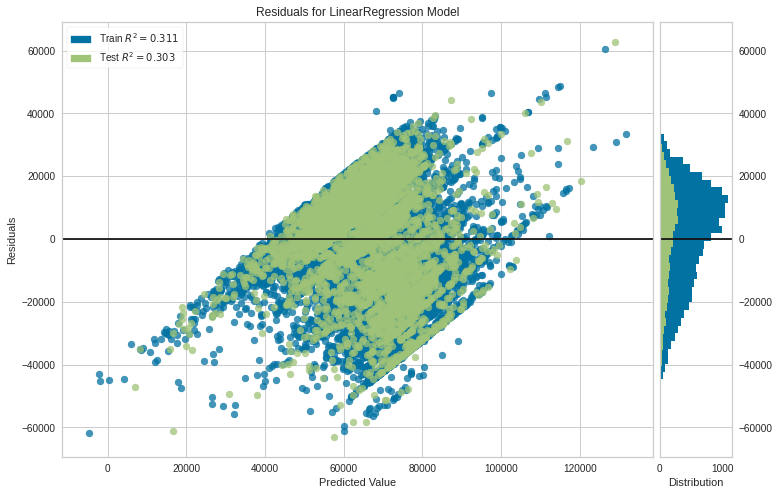

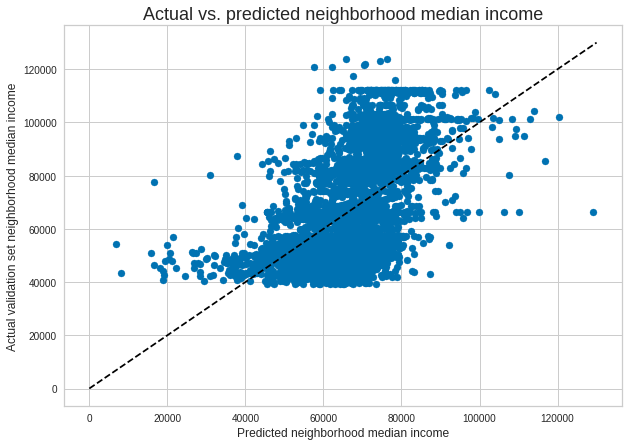

In [ ]:
# Plot residual errors
plt.figure(figsize=[12,8])
visualizer = ResidualsPlot(lm)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)    # Evaluate the model on the validation data
visualizer.show()                        # Finalize and render the figure

# Plot predictions against actuals
plt.figure(figsize=(10,7))
plt.title("Actual vs. predicted neighborhood median income",fontsize=18)
plt.xlabel("Predicted neighborhood median income",fontsize=12)
plt.ylabel("Actual validation set neighborhood median income", fontsize=12)
a = range(0,130001)
b = a
plt.plot(a,b, color='black', linestyle='dashed')
plt.scatter(x=y_pred,y=y_val)

**Findings from residual plots** 
- Both of the plots above show clear trend in model error as income level increases, with low income areas consistently predicted as too high, middle income areas predicted accurately (on average), and higher income areas predicted as too low. 

### Feature Selection

#### LASSO Regression

In [ ]:
# Instantiate the LASSO regressor
lasso = linear_model.Lasso(tol=0.01, max_iter=10000)

# Setup the pipeline to standardize the data prior to running the LASSO regression
steps = [('scaler', StandardScaler()),
         ('lasso', lasso)]
pipeline = Pipeline(steps)

# Create the hyperparameter grid
alpha_space = np.linspace(0.001, 10, 40)
param_grid = {'lasso__alpha': alpha_space}

# Define scoring metrics
metrics = {'r2': 'r2',
           'mape': 'neg_mean_absolute_percentage_error',
           'mae': 'neg_mean_absolute_error'}

# Instantiate the GridSearchCV object:
lasso_cv = GridSearchCV(pipeline,
                        param_grid=param_grid,
                        scoring=metrics,
                        refit='mape',
                        return_train_score = True,
                        cv=5)

# Fit the model to the training data
lasso_cv.fit(X_train, y_train)

# View training results
results = lasso_cv.cv_results_
scores = pd.DataFrame(0, columns=['R^2', 'MAPE', 'MAE'], index=['CV','Train'])
scores.loc['CV','R^2'] = np.mean(results['mean_test_r2'])
scores.loc['CV','MAPE'] = np.mean(results['mean_test_mape'])
scores.loc['CV','MAE'] = np.mean(results['mean_test_mae'])
scores.loc['Train','R^2'] = np.mean(results['mean_train_r2'])
scores.loc['Train','MAPE'] = np.mean(results['mean_train_mape'])
scores.loc['Train','MAE'] = np.mean(results['mean_train_mae'])
print("Training Results:")
display(scores)

print("Best alpha value: {alpha}\n".format(alpha=lasso_cv.best_params_))

# Calculate error metrics on validation data
val_stats = pd.DataFrame(0, columns=['R^2', 'MAPE', 'MAE'], index=['Val'])
y_pred = lasso_cv.best_estimator_.predict(X_val)
val_stats.loc['Val','R^2'] = lasso_cv.best_estimator_.score(X_val, y_val)
val_stats.loc['Val','MAPE'] = lasso_cv.score(X_val, y_val)
val_stats.loc['Val','MAE'] = mean_absolute_error(y_val, y_pred)
print("Validation Results:")
display(val_stats)
print(lasso_cv.best_estimator_.named_steps['lasso'].coef_)

Training Results:


,R^2,MAPE,MAE
CV,0.295854,-0.219273,-14006.760526
Train,0.312528,-0.216660,-13846.603160


Best alpha value: {'lasso__alpha': 9.743615384615383}

Validation Results:


,R^2,MAPE,MAE
Val,0.305181,-0.212372,13599.399562


[-3.023e+03 -4.139e+02  4.568e+02 -8.714e+02 -1.856e+03  0.000e+00
 -0.000e+00 -3.052e+03  5.362e+02 -2.278e+02 -2.663e+00 -1.484e+03
 -1.680e+03  6.058e+02 -0.000e+00  5.937e+02 -4.479e+02  0.000e+00
  1.247e+03  5.738e+03  1.490e+03  1.635e+03 -1.492e+04  3.904e+02
 -3.638e+03 -0.000e+00 -2.670e+02 -7.478e+02  3.805e+02 -2.216e+03
  2.197e+03  5.423e+01 -9.604e+01  1.353e+03 -1.616e+03 -3.006e+03
  1.965e+02  8.227e+01  3.904e+02 -1.355e+02 -1.731e+01  0.000e+00
 -1.126e+02 -1.375e+02 -3.164e+02 -1.094e+03  1.131e+03 -9.102e+02
  1.224e+01 -4.429e+02  1.856e+02  1.062e+03 -8.331e+02 -5.309e+02
 -0.000e+00  5.920e+02 -3.001e+02 -2.172e+03 -3.119e+03 -3.874e+03
  7.960e+01  3.595e+03 -2.662e+02 -9.339e+02 -0.000e+00  1.956e+01
  7.825e+02 -2.511e+02  2.976e+02 -3.840e+03 -5.299e+02 -0.000e+00
 -3.105e+03  4.414e+02  7.686e+02 -1.216e+03 -5.797e+02 -9.753e+02
  2.337e+03  1.097e+02 -4.705e+02  3.576e+02  2.502e+03 -0.000e+00
  4.802e+02  1.928e+03  0.000e+00  5.230e+01 -1.334e+02  1.969

In [ ]:
# Count coefficients = 0
lasso_coefs = lasso_cv.best_estimator_.named_steps['lasso'].coef_
print("The LASSO regression set {coefs} parameters to 0.".format(coefs = np.count_nonzero(lasso_coefs == 0)))

The LASSO regression set 22 parameters to 0.


In [ ]:
# Select column indices for all features set to 0
lasso_coefs = [-3.023e+03, -4.139e+02, 4.568e+02, -8.714e+02, -1.856e+03, 0.000e+00
, -0.000e+00, -3.052e+03, 5.362e+02, -2.278e+02, -2.663e+00, -1.484e+03
, -1.680e+03, 6.058e+02, -0.000e+00, 5.937e+02, -4.479e+02, 0.000e+00
, 1.247e+03, 5.738e+03, 1.490e+03, 1.635e+03, -1.492e+04, 3.904e+02
, -3.638e+03, -0.000e+00, -2.670e+02, -7.478e+02, 3.805e+02, -2.216e+03
, 2.197e+03, 5.423e+01, -9.604e+01, 1.353e+03, -1.616e+03, -3.006e+03
, 1.965e+02, 8.227e+01, 3.904e+02, -1.355e+02, -1.731e+01, 0.000e+00
, -1.126e+02, -1.375e+02, -3.164e+02, -1.094e+03, 1.131e+03, -9.102e+02
, 1.224e+01, -4.429e+02, 1.856e+02, 1.062e+03, -8.331e+02, -5.309e+02
, -0.000e+00, 5.920e+02, -3.001e+02, -2.172e+03, -3.119e+03, -3.874e+03
, 7.960e+01, 3.595e+03, -2.662e+02, -9.339e+02, -0.000e+00, 1.956e+01
, 7.825e+02, -2.511e+02, 2.976e+02, -3.840e+03, -5.299e+02, -0.000e+00
, -3.105e+03, 4.414e+02, 7.686e+02, -1.216e+03, -5.797e+02, -9.753e+02
, 2.337e+03, 1.097e+02, -4.705e+02, 3.576e+02, 2.502e+03, -0.000e+00
, 4.802e+02, 1.928e+03, 0.000e+00, 5.230e+01, -1.334e+02, 1.969e+03
, 9.256e+02, 1.780e+02, 1.469e+02, -4.795e+02, 5.261e+00, -0.000e+00
, -0.000e+00, -5.734e+03, 1.995e+02, -0.000e+00, 2.047e+04, -1.083e+02
, -4.496e+03, 8.547e+01, 4.922e+02, 0.000e+00, 0.000e+00, 2.112e+03
, -8.879e+02, 1.273e+03, -6.292e+02, 3.354e+02, 2.357e+03, 2.260e+03
, -0.000e+00, 6.986e+02, 7.336e+01, -1.783e+02, 1.605e+02, -0.000e+00
, 1.121e+02, 2.809e+01, -4.596e+01, 5.895e+01, -4.128e+02, -4.403e+01
, -6.124e+01, 0.000e+00, 0.000e+00, 4.882e+01, -5.956e+01, -6.497e+01
, -6.180e+01, -8.066e+01, 3.209e+01, 2.687e+02, -4.065e+02, 2.287e+02
, -0.000e+00, -1.043e+03, 0.000e+00, 2.883e+02, 4.678e+02, -7.480e+00
, 5.121e+01, -1.126e+02, 2.823e+01, 1.217e+01, -6.104e+01, -8.622e+01
, -9.718e+01, -9.853e+00, 1.329e+02, 1.562e+02, -1.214e+02, -3.289e+02]
lasso_coefs = pd.DataFrame(lasso_coefs)
rejected = lasso_coefs[lasso_coefs[0] == 0].index.to_list()
rejected

[5,
 6,
 14,
 17,
 25,
 41,
 54,
 64,
 71,
 83,
 86,
 95,
 96,
 99,
 105,
 106,
 114,
 119,
 127,
 128,
 138,
 140]

The LASSO results provide confidence that at least 22 predictors can be removed from the model without sacrificing explanatory power or prediction accuracy. In fact, both are slightly better from the LASSO regression, although not significantly.

Next we'll try a recursive feature elimination algorithm to compare results on rejected variables.

Lastly, we'll run a simple forward stepwise selection regression to select only the top 30 features.

#### Recursive Feature Elimination with Cross-Validation

In [ ]:
linreg = linear_model.LinearRegression()
selector = RFECV(linreg, step=1, cv=5)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True  True  True  True False  True  True  True  True
 False  True  True False  True  True  True False  True  True  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True False  True  True  True  True  True False False  True False  True
  True  True  True  True  True  True False  True False  True  True  True
  True  True False False False  True  True False  True  True  True  True]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  1  

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but RFECV was fitted with feature names



In [ ]:
# Count coefficients = 0
print("The Recursive Elimination method also set {coefs} parameters to 0.".format(coefs = selector.support_.shape[0] - selector.support_.sum())) 

The Recursive Elimination method also set 22 parameters to 0.


In [ ]:
# Select indices for variables to drop from RFECV
rfecv_coefs = pd.DataFrame([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1
, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 15, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1
, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 17, 1, 1, 22, 1, 1, 1, 1, 12, 1, 1, 1, 1
, 8, 1, 1, 16, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 13, 1, 1, 1
, 1, 9, 1, 1, 1, 1, 1, 21, 20, 1, 2, 1, 1, 1, 1, 1, 1, 1, 23, 1, 11, 1, 1, 1
, 1, 1, 14, 18, 10, 1, 1, 19, 1, 1, 1, 1])
rfecv_drop = rfecv_coefs[rfecv_coefs[0] != 1].index.to_list()
rfecv_drop

[14,
 25,
 60,
 64,
 83,
 86,
 91,
 96,
 99,
 103,
 111,
 116,
 121,
 127,
 128,
 130,
 138,
 140,
 146,
 147,
 148,
 151]

#### Stepwise Selection

In [ ]:
linreg = linear_model.LinearRegression()

# Forward selection
tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(
    linreg, n_features_to_select=30, direction="forward"
).fit(X_train, y_train)
toc_fwd = time.time()

In [ ]:
# Print results
print(
    "Features selected by forward sequential selection: "
    f"{X_train.loc[:,sfs_forward.get_support()].columns.to_list()}" 
)
print(f"Done in {(toc_fwd - tic_fwd)//60:.0f}m {(toc_fwd - tic_fwd)%60:.0f}s")

Features selected by forward sequential selection: ['311 DOCUMENT_VOL', 'ANIMAL FOUND REPORT_VOL', 'CART_VOL', 'GARBAGE_VOL', 'HNS HOUSING_VOL', 'MISSED SERVICE_VOL', 'NON_RECYCLABLE ITEMS_VOL', 'RECYCLABLE ITEMS_VOL', 'TIRES_VOL', 'VIOLATIONS_VOL', 'BULKY ITEM_STD', 'CONTENT IMPROVEMENT PROG_STD', 'GARBAGE_STD', 'HNS HEALTH AND SANITATION_STD', 'HNS HOUSING_STD', 'NON_RECYCLABLE ITEMS_STD', 'TIRES_STD', 'VIOLATIONS_STD', 'ZON GENERAL INFO  INQUIRY_STD', 'ZONING/COMPLAINT/ INSPECT_STD', '311 DOCUMENT_DIST', 'CART_DIST', 'CUSTOMER FEEDBACK_DIST', 'NON_RECYCLABLE ITEMS_DIST', 'RECYCLABLE ITEMS_DIST', 'TRANSPORTATION_DIST', 'UTILITY VERIFICATION LTR_DIST', 'WEATHER AND ENVIRONMENTAL_DIST', 'NON_RECYCLABLE ITEMS_LATE', 'RECYCLING_LATE']
Done in 6m 36s


### Modeling with Selected Features

Before modeling, we'll need to first check if the multicollinearity problem has been reduced by the feature removal prior to making any inferences from the parameter estimates. 

First, we'll check the "large model" option of removing the parameters rejected by both LASSO and RFECV.

#### Model 1 - Large Model Option

In [ ]:
# Remove rejected features
drop_feats = rejected + rfecv_drop
X2 = X.drop(X.columns[drop_feats], axis=1)

In [ ]:
# Recheck VIF for the reduced feature set
# Add intercept term to X2
X2['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X2.columns
vif["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
print(vif[vif.VIF >= 5].sort_values('VIF', ascending=False))

                        variables        VIF
86          RECYCLABLE ITEMS_DIST  68.793955
20           RECYCLABLE ITEMS_VOL  67.866161
88  SW ONLY-DOOR HANGER LEFT_DIST  62.924995
18       NON_RECYCLABLE ITEMS_VOL  60.587955
84      NON_RECYCLABLE ITEMS_DIST  58.625099
..                            ...        ...
28                 VIOLATIONS_VOL   5.613735
40                       CART_STD   5.417927
62                 VIOLATIONS_STD   5.378327
55           RECYCLABLE ITEMS_STD   5.269658
65  ZON GENERAL INFO  INQUIRY_STD   5.227204

[90 rows x 2 columns]


Clearly, there still exists far too much multicollinearity in this feature set, though we have reduced from 115 features with VIF over 5 to 90, and from a high of 89 to only 69. That said, even a highly L2-regularized model could not sufficiently compensate for this level of inflation, so the top 30 features may be the best option.

#### Model 2 - Top 30 Model Option

In [ ]:
# Keep only the top 30 features
X3 = X.loc[:,sfs_forward.get_support()]
X3.head()

,311 DOCUMENT_VOL,ANIMAL FOUND REPORT_VOL,CART_VOL,GARBAGE_VOL,HNS HOUSING_VOL,MISSED SERVICE_VOL,NON_RECYCLABLE ITEMS_VOL,RECYCLABLE ITEMS_VOL,TIRES_VOL,VIOLATIONS_VOL,BULKY ITEM_STD,CONTENT IMPROVEMENT PROG_STD,GARBAGE_STD,HNS HEALTH AND SANITATION_STD,HNS HOUSING_STD,NON_RECYCLABLE ITEMS_STD,TIRES_STD,VIOLATIONS_STD,ZON GENERAL INFO INQUIRY_STD,ZONING/COMPLAINT/ INSPECT_STD,311 DOCUMENT_DIST,CART_DIST,CUSTOMER FEEDBACK_DIST,NON_RECYCLABLE ITEMS_DIST,RECYCLABLE ITEMS_DIST,TRANSPORTATION_DIST,UTILITY VERIFICATION LTR_DIST,WEATHER AND ENVIRONMENTAL_DIST,NON_RECYCLABLE ITEMS_LATE,RECYCLING_LATE
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2016_10.0,1.127806,0.0,6.766838,1.127806,1.879677,0.375935,31.954512,6.766838,0.375935,0.375935,0.276385,0.0,0.438986,0.816497,0.406116,2.272648,0.199826,0.199826,0.199826,0.199826,3.0,11.0,0.0,77.0,17.0,2.0,0.0,1.0,0.176471,0.0
10_2016_100.0,0.637888,0.0,1.275775,0.318944,0.000000,0.000000,13.395640,4.784157,0.000000,0.000000,0.000000,0.0,0.212959,1.003396,0.000000,1.690309,0.000000,0.000000,0.000000,0.000000,2.0,4.0,0.0,35.0,14.0,1.0,0.0,0.0,0.119048,0.0
10_2016_101.0,0.000000,0.0,0.323053,0.000000,0.323053,0.000000,1.615263,1.615263,0.000000,0.000000,0.000000,0.0,0.000000,0.287480,0.287480,0.497930,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,3.0,4.0,1.0,0.0,0.0,0.600000,0.0
10_2016_102.0,0.000000,0.0,0.633837,0.316918,0.316918,0.000000,6.338370,1.901511,0.000000,0.000000,0.000000,0.0,0.242061,1.356408,0.242061,0.901388,0.000000,0.000000,0.242061,0.000000,0.0,1.0,0.0,16.0,5.0,2.0,0.0,0.0,0.200000,0.0
10_2016_103.0,0.323053,0.0,0.646105,0.000000,0.000000,0.000000,6.138000,1.938316,0.000000,0.000000,0.000000,0.0,0.000000,0.728431,0.000000,1.171516,0.000000,0.000000,0.000000,0.000000,1.0,2.0,0.0,17.0,6.0,0.0,0.0,0.0,0.105263,0.0


In [ ]:
# Recheck VIF for the reduced feature set
# Add intercept term to X3
X3['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X3.columns
vif["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
print(vif[vif.VIF >= 5].sort_values('VIF', ascending=False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                    variables        VIF
24      RECYCLABLE ITEMS_DIST  63.466226
7        RECYCLABLE ITEMS_VOL  60.541642
23  NON_RECYCLABLE ITEMS_DIST  51.644788
6    NON_RECYCLABLE ITEMS_VOL  50.033185
0            311 DOCUMENT_VOL  20.149724
20          311 DOCUMENT_DIST  19.591961
21                  CART_DIST   9.249352
3                 GARBAGE_VOL   7.357786
2                    CART_VOL   6.746070
30                  intercept   6.714830
8                   TIRES_VOL   6.258659
12                GARBAGE_STD   6.093920
16                  TIRES_STD   5.623552
15   NON_RECYCLABLE ITEMS_STD   5.491807
9              VIOLATIONS_VOL   5.213450
4             HNS HOUSING_VOL   5.053047


With only 6 values over 10, we're much closer to a useable feature set. We'll next try dropping the top 3 _DIST variables, which seem to be the culprits of the highest remaining multicollinearity.

In [ ]:
# Drop features
X3.drop(columns=['RECYCLABLE ITEMS_DIST', 'NON_RECYCLABLE ITEMS_DIST', '311 DOCUMENT_DIST'], inplace=True)

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X3.columns
vif["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
print(vif[vif.VIF >= 5].sort_values('VIF', ascending=False))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                   variables        VIF
6   NON_RECYCLABLE ITEMS_VOL  10.665855
20                 CART_DIST   7.815327
3                GARBAGE_VOL   6.997370
27                 intercept   6.610670
8                  TIRES_VOL   6.135931
2                   CART_VOL   6.027074
12               GARBAGE_STD   5.838272
16                 TIRES_STD   5.502183
7       RECYCLABLE ITEMS_VOL   5.320902
9             VIOLATIONS_VOL   5.175603
15  NON_RECYCLABLE ITEMS_STD   5.160458


With only one variable showing a VIF above 10, we should be able to control for that multicollinearity through a Ridge regression, expecting the coefficients on the NON_RECYCLABLE ITEMS variables to be reduced by the L2 norm penalty. However, since the best model so far was the LASSO, we'll combine the two methods by using the ElasticNet Regression.

### Chosen Model for Target: Median Income -- ElasticNet Regression

In [ ]:
# Resplit training and test sets on new feature set
X3.drop(columns='intercept', inplace=True)
X_sub, X_test, y_sub, y_test = train_test_split(X3, y, test_size=0.1, random_state=161)
X_train, X_val, y_train, y_val = train_test_split(X_sub, y_sub, test_size=0.2, random_state=161)

In [ ]:
# Instantiate the ElasticNet regressor
elnet = linear_model.ElasticNet(tol=0.000001, 
                                max_iter=100000,
                                random_state=161,
                                selection='random')

# Setup the pipeline to standardize the data prior to running the ElasticNet regression
steps = [('scaler', StandardScaler()),
         ('elnet', elnet)]
pipeline = Pipeline(steps)

# Create the hyperparameter grid
alpha_space = np.logspace(-8, 1, 10)
l1_space = np.arange(0.02, 1, 0.08)
param_grid = {'elnet__alpha': alpha_space,
              'elnet__l1_ratio': l1_space}

# Define scoring metrics
metrics = {'r2': 'r2',
           'mape': 'neg_mean_absolute_percentage_error',
           'mae': 'neg_mean_absolute_error'}

# Instantiate the GridSearchCV object:
elnet_cv = GridSearchCV(pipeline,
                        param_grid=param_grid,
                        scoring=metrics,
                        refit='mape',
                        return_train_score = True,
                        cv=5)

# Fit the model to the training data
elnet_cv.fit(X_train, y_train)
y_pred = elnet_cv.predict(X_val)

#View training results
results = elnet_cv.cv_results_
scores = pd.DataFrame(0, columns=['R^2', 'MAPE', 'MAE'], index=['CV','Train'])
scores.loc['CV','R^2'] = np.mean(results['mean_test_r2'])
scores.loc['CV','MAPE'] = np.mean(results['mean_test_mape'])
scores.loc['CV','MAE'] = np.mean(results['mean_test_mae'])
scores.loc['Train','R^2'] = np.mean(results['mean_train_r2'])
scores.loc['Train','MAPE'] = np.mean(results['mean_train_mape'])
scores.loc['Train','MAE'] = np.mean(results['mean_train_mae'])
print("Training Results:")
display(scores)

print("Best alpha value: {alpha}\n".format(alpha=elnet_cv.best_params_))

# Print mean validation errors and R-squared
pd.options.display.float_format = '{:.4f}'.format
scores = pd.DataFrame(0, columns=['R^2', 'MAPE', 'MAE'], index=['Val'])
scores.loc['Val','R^2'] = r2_score(y_val, y_pred)
scores.loc['Val','MAPE'] = mean_absolute_percentage_error(y_val, y_pred)
scores.loc['Val','MAE'] = mean_absolute_error(y_val, y_pred)
display(scores)

# Calculate F-statistic and its p-value
Rsq = scores.loc['Val','R^2']
n = X_train.shape[0]
k = X_train.shape[1]
dfN = n - k
fstat = (Rsq/(1-Rsq))*((dfN-1)/k)
f_pval = 1 - sm.F(k - 1, n - k).cdf(fstat)
print("F-statistic:", np.round(fstat,3))
print("F's p-value:", f_pval)

# Collect the model coefficients
idict = {'Coefficient':elnet_cv.best_estimator_.named_steps['elnet'].intercept_}
idf = pd.DataFrame(data=idict,index=['Intercept'])
cdf = pd.DataFrame(data=elnet_cv.best_estimator_.named_steps['elnet'].coef_, index=X_train.columns, columns=["Coefficient"])
cdf = pd.concat([idf,cdf], axis=0)

# Calculate and add in standard errors, t-statistics, and p-values
X_train_wint = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train.reset_index(drop=True))) # X_train with constant intercept column added
train_pred=elnet_cv.predict(X_train)
MSE = sum(np.square(train_pred - y_train))/(dfN-1)
var = MSE*(np.linalg.inv(np.dot(X_train_wint.T, X_train_wint)).diagonal())
se = np.sqrt(var)
cdf['Standard Error'] = se
cdf['t-statistic'] = cdf['Coefficient'] / cdf['Standard Error']
cdf['Probabilities'] = [2*scipy.stats.t.sf(abs(i), dfN) for i in cdf['t-statistic']]

# Add some pretty R-style significance codes
sig_codes = ["***", "**", "*", ".", ""]
sig_levels = [-np.inf, 0.001, 0.01, 0.05, 0.1, np.inf]
cdf['*'] = pd.cut(cdf['Probabilities'], bins=sig_levels, labels=sig_codes)
cdf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e+08, tolerance: 5.478e+06

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.495e+07, tolerance: 5.477e+06



Training Results:


,R^2,MAPE,MAE
CV,0.2354,-0.2306,-14710.8982
Train,0.2384,-0.2301,-14684.7921


Best alpha value: {'elnet__alpha': 1e-08, 'elnet__l1_ratio': 0.98}



,R^2,MAPE,MAE
Val,0.2584,0.2203,14085.1628


F-statistic: 216.653
F's p-value: 1.1102230246251565e-16


,Coefficient,Standard Error,t-statistic,Probabilities,*
Intercept,66650.2582,347.0650,192.0397,0.0000,***
311 DOCUMENT_VOL,-1088.6275,415.2706,-2.6215,0.0088,**
ANIMAL FOUND REPORT_VOL,-615.5623,2095.0666,-0.2938,0.7689,
CART_VOL,-5264.7279,178.0971,-29.5610,0.0000,***
GARBAGE_VOL,-706.9349,646.8083,-1.0930,0.2744,
HNS HOUSING_VOL,619.6983,1103.6892,0.5615,0.5745,
MISSED SERVICE_VOL,1135.5646,168.2036,6.7511,0.0000,***
NON_RECYCLABLE ITEMS_VOL,1873.9948,52.5262,35.6774,0.0000,***
RECYCLABLE ITEMS_VOL,-7348.7368,138.6091,-53.0177,0.0000,***
TIRES_VOL,648.6968,1148.1251,0.5650,0.5721,


The model above shows that after correcting for multicollinearity in the predictors, 11 variables pertaining to 311 requests are highly significant features in predicting median income level of their respective neighborhoods. The model can account for roughly 25% of the varaibility in median income, and can do so with an average error of 22%, or approximately	$14,000.

Some of the observed effects are summarized below:

CART_VOL: Number of requests in the CART category per 1,000 people in one month
- From an increase by 1 request per thousand citizens in the average monthly volume of CART requests for a given neighborhood, we can expect with 95% confidence that our model's prediction of that neighborhood's median income will be between \$4,908 and \$5,621 lower. That is, poorer neighborhoods appear to have a higher per capita volume of CART-related requests.

RECYCLABLE ITEMS_VOL: Number of recyclable items requests per 1,000 people in one month
- From an increase by 1 request per thousand citizens in the average monthly volume of RECYCLABLE ITEMS requests for a given neighborhood, we can expect with 95% confidence that our model's prediction of that neighborhood's median income will be between \$7,072 and \$7,626 lower. Likewise, poorer neighborhoods appear to have a higher volume of recycling requests.

NON_RECYCLABLE ITEMS_VOL: Number of non-recyclable items requests per 1,000 people in one month
- From an increase by 1 request per thousand citizens in the average monthly volume of NON_RECYCLABLE ITEMS requests for a given neighborhood, we can expect with 95% confidence that our model's prediction of that neighborhood's median income will be between \$1,769 and \$1,979 _higher_. In this case, _richer_ neighborhoods appear to have a higher volume of non-recyclable requests.

# Section 2 -- Target: Historic Redlining

In [ ]:
# Subset selected variables from above section. 
X = areas.iloc[:, 0:156]
top30 = ['311 DOCUMENT_VOL', 'ANIMAL FOUND REPORT_VOL', 'CART_VOL', 'GARBAGE_VOL', 'HNS HOUSING_VOL', 'MISSED SERVICE_VOL', 'NON_RECYCLABLE ITEMS_VOL', 'RECYCLABLE ITEMS_VOL', 'TIRES_VOL', 'VIOLATIONS_VOL', 'BULKY ITEM_STD', 'CONTENT IMPROVEMENT PROG_STD', 'GARBAGE_STD', 'HNS HEALTH AND SANITATION_STD', 'HNS HOUSING_STD', 'NON_RECYCLABLE ITEMS_STD', 'TIRES_STD', 'VIOLATIONS_STD', 'ZON GENERAL INFO  INQUIRY_STD', 'ZONING/COMPLAINT/ INSPECT_STD', '311 DOCUMENT_DIST', 'CART_DIST', 'CUSTOMER FEEDBACK_DIST', 'NON_RECYCLABLE ITEMS_DIST', 'RECYCLABLE ITEMS_DIST', 'TRANSPORTATION_DIST', 'UTILITY VERIFICATION LTR_DIST', 'WEATHER AND ENVIRONMENTAL_DIST', 'NON_RECYCLABLE ITEMS_LATE', 'RECYCLING_LATE']
X3 = X.loc[:, top30]
X3.drop(columns=['RECYCLABLE ITEMS_DIST', 'NON_RECYCLABLE ITEMS_DIST', '311 DOCUMENT_DIST'], inplace=True)
y_cat = areas.iloc[:, 158]

# Create a binary target and check class distribution
y_cat_bin = areas.iloc[:, 158].apply(lambda x: 0 if (x == 'N') else (1))
print("Out of {records} records, {ones} are in a redlined category".format(ones = y_cat_bin.sum(), records = X3.shape[0]))

Out of 23350 records, 2131 are in a redlined category


Because of the disparity in classes, we'll need to oversample prior to modeling.

In [ ]:
# Split training, validation, and test data sets
X_sub, X_test, y_sub, y_test = train_test_split(X3, y_cat_bin, test_size=0.1, random_state=161)
X_train, X_val, y_train, y_val = train_test_split(X_sub, y_sub, test_size=0.2, random_state=161)

# Oversample
oversampler = SMOTE()
X_train, y_train = oversampler.fit_resample(X_train, y_train)
print("Out of {records} training records, {ones} are in a redlined category".format(ones = y_train.sum(), records = X_train.shape[0]))

Out of 30512 training records, 15256 are in a redlined category


In [ ]:
# Instantiate the ElasticNet logistic regressor
lognet = linear_model.LogisticRegression(tol=0.00001, 
                                         max_iter=10000,
                                         penalty = 'elasticnet',
                                         random_state=161,
                                         solver='saga')

# Setup the pipeline to standardize the data prior to running the ElasticNet logistic regression
steps = [('scaler', StandardScaler()),
         ('lognet', lognet)]
pipeline = Pipeline(steps)

# Create the hyperparameter grid
C_space = [1] # a previous run showed 1 to be the ideal C value
l1_space = [0.01, 0.1, 0.2, 0.5, 0.7, 0.9, 0.98, 1.]
param_grid = {'lognet__C': C_space,
              'lognet__l1_ratio': l1_space}

# Define scoring metrics
metrics = {'acc': 'accuracy',
           'f1': 'f1',
           'auc': 'roc_auc'}

# Instantiate the GridSearchCV object: (GridSearchCV defaults to StratifiedKFold if the target is binary)
lognet_cv = GridSearchCV(pipeline,
                        param_grid=param_grid,
                        scoring=metrics,
                        refit='auc',
                        return_train_score = True,
                        cv=5)

# Fit the model to the training data
lognet_cv.fit(X_train, y_train)
y_pred = lognet_cv.best_estimator_.predict(X_val)

#View training results
results = lognet_cv.cv_results_
scores = pd.DataFrame(0, columns=['Acc', 'F1', 'AUC'], index=['CV','Train'])
scores.loc['CV','Acc'] = np.mean(results['mean_test_acc'])
scores.loc['CV','F1'] = np.mean(results['mean_test_f1'])
scores.loc['CV','AUC'] = np.mean(results['mean_test_auc'])
scores.loc['Train','Acc'] = np.mean(results['mean_train_acc'])
scores.loc['Train','F1'] = np.mean(results['mean_train_f1'])
scores.loc['Train','AUC'] = np.mean(results['mean_train_auc'])
print("Training Results:")
display(scores)

print("Best parameters: {params}\n".format(params=lognet_cv.best_params_))

# Print validation metrics
pd.options.display.float_format = '{:.4f}'.format
scores = pd.DataFrame(0, columns=['Acc', 'F1', 'AUC'], index=['Val'])
scores.loc['Val','Acc'] = accuracy_score(y_val, y_pred)
scores.loc['Val','F1'] = f1_score(y_val, y_pred)
scores.loc['Val','AUC'] = roc_auc_score(y_val, lognet_cv.best_estimator_.predict_proba(X_val)[:, 1])
display(scores)

# Collect the model coefficients
idict = {'Coefficient':lognet_cv.best_estimator_.named_steps['lognet'].intercept_}
idf = pd.DataFrame(data=idict,index=['Intercept'])
cdf = pd.DataFrame(data=lognet_cv.best_estimator_.named_steps['lognet'].coef_.transpose(), index=X_train.columns, columns=["Coefficient"])
cdf = pd.concat([idf,cdf], axis=0)

# Calculate and add in standard errors, t-statistics, and p-values
X_train_wint = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train.reset_index(drop=True))) # X_train with constant intercept column added
train_pred = lognet_cv.best_estimator_.predict_proba(X_train)

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.diagflat(np.product(train_pred, axis=1))

# Covariance matrix (@-operater does matrix multiplication)
covLogit = np.linalg.inv(X_train_wint.T @ V @ X_train_wint)

# Standard errors, Z-scores, and p-values
dfN = X_train.shape[0] - X_train.shape[1]
cdf['Standard Error'] = np.sqrt(np.diag(covLogit))
cdf['Z-statistic'] = cdf['Coefficient'] / cdf['Standard Error']
cdf['Probabilities'] = [2*scipy.stats.t.sf(abs(i), dfN) for i in cdf['Z-statistic']]

# Add some pretty R-style significance codes
sig_codes = ["***", "**", "*", ".", ""]
sig_levels = [-np.inf, 0.001, 0.01, 0.05, 0.1, np.inf]
cdf['*'] = pd.cut(cdf['Probabilities'], bins=sig_levels, labels=sig_codes)
cdf

Training Results:


,Acc,F1,AUC
CV,0.740315,0.730945,0.817896
Train,0.741877,0.732424,0.818804


Best parameters: {'lognet__C': 1, 'lognet__l1_ratio': 1.0}



,Acc,F1,AUC
Val,0.7642,0.3424,0.7949


,Coefficient,Standard Error,Z-statistic,Probabilities,*
Intercept,0.2013,0.0359,5.6058,0.0000,***
311 DOCUMENT_VOL,0.1345,0.0440,3.0569,0.0022,**
ANIMAL FOUND REPORT_VOL,-0.0418,0.2255,-0.1852,0.8531,
CART_VOL,1.8250,0.0263,69.4842,0.0000,***
GARBAGE_VOL,1.1403,0.0861,13.2375,0.0000,***
HNS HOUSING_VOL,0.4178,0.1429,2.9230,0.0035,**
MISSED SERVICE_VOL,0.5203,0.0207,25.1916,0.0000,***
NON_RECYCLABLE ITEMS_VOL,1.2289,0.0059,207.8920,0.0000,***
RECYCLABLE ITEMS_VOL,-0.8014,0.0157,-51.0275,0.0000,***
TIRES_VOL,0.2756,0.1369,2.0128,0.0441,*


The model above shows that 14 variables pertaining to 311 requests are highly significant features in predicting whether a neighborhood was historically a redlined district. The model can predict redlining status with 76% accuracy.

Some of the observed effects are summarized below:

CART_VOL: Number of requests in the CART category per 1,000 people in one month
- From an increase of 1 request per thousand citizens in the average monthly volume of CART requests for a given neighborhood, we can expect with 95% confidence that the odds of that neighborhood being labeled a historically redlined district will increase by a factor between 5.8 and 6.5. That is, higher per capita volume of CART-related requests is positively associated with historically redlined districts. The accuracy of the model's assigned label of course remains only 76%.

RECYCLABLE ITEMS_VOL: Number of recyclable items requests per 1,000 people in one month
- From an increase by 1 request per thousand citizens in the average monthly volume of RECYCLABLE ITEMS requests for a given neighborhood, we can expect with 95% confidence that the odds of that neighborhood being labeled a historically redlined district will _decrease_ by a factor between 0.46 and 0.43 -- roughly a 55% reduction in the odds. That is, higher per capita volume of _RECYCLABLE_ ITEM-related requests is _negatively_ associated with historically redlined districts. The accuracy of the model's assigned label of course remains only 76%.

NON_RECYCLABLE ITEMS_VOL: Number of non-recyclable items requests per 1,000 people in one month
- From an increase by 1 request per thousand citizens in the average monthly volume of NON_RECYCLABLE ITEMS requests for a given neighborhood, we can expect with 95% confidence that the odds of that neighborhood being labeled a historically redlined district will increase by a factor between 3.37 and 3.46. That is, higher per capita volume of NON-RECYCLABLE ITEM-related requests is positively associated with historically redlined districts. The accuracy of the model's assigned label of course remains only 76%.